In [1]:
import streamlit as st
from utils import filtrar
from data import load_data
import pandas as pd
import numpy as np
import requests
import soft
import tech
import tech_
from pprint import pprint
import plotly.express as px


tables_id = {"Trabajadores"               : "tblNBHV9KDGDQNs8y",
             "Roles"                      : "tblk2itGEWE7ePo73",
             "Tecnologías"                : "tblXhF1lZUBKiNixP",
             "Competencias técnicas"      : "tblLUDGmhm7otZhGp",
             "Competencias blandas"       : "tblvuUUjjnUvdS1z1",
             "Certificaciones"            : "tblUforpTYin3pEZs",
             "Formulario certificaciones" : "tblERjkIA64JGPgNW",
             "Pruebas técnicas"           : "tblGy8pLPexkcpJcq",
             "Verticales"                 : "tblDZzmvFmWfMbmx5",
             "Assessment MAPFRE"          : "tbl7EYNl618IhKAse",
             "Data blandas"               : "tblImXJh9fSnqrW8B",
             "Data Competencias técnicas" : "tbl1kSY13iQhxi1O3",
             "Data Tecnologías"           : "tblca2y3nQTUPrbfx"}

def extract_airtable(app: str, tbl: str, token: str) -> pd.DataFrame:
    url = f"https://api.airtable.com/v0/{app}/{tbl}"

    response = requests.get(url, headers={"Authorization" : f"Bearer {"patAavpcVDkODOexK.4077431682eb04c6617a62752b02d81efc3031128fc8294b2328d4e18d5233bb"}"})
    data = response.json()
    records = data["records"]

    while "offset" in data.keys():
        r = requests.get(url, headers={"Authorization" : f"Bearer {token}"}, params={"offset" : data["offset"]})
        data = r.json()
        records.extend(data["records"])

    return pd.json_normalize(records)

def extract_all_airtable(tables_id: dict) -> dict:

    AIRTABLE_API_KEY = "patAavpcVDkODOexK.4077431682eb04c6617a62752b02d81efc3031128fc8294b2328d4e18d5233bb"

    app_id = "appACxf1z2b7fsR44"

    df_dicts = dict()
    for k, v in tables_id.items():
        
        df_bucle = extract_airtable(app = app_id, tbl = v, token = AIRTABLE_API_KEY).drop(["createdTime"], axis = 1)

        df_bucle.columns = [col.replace("fields.", "") for col in df_bucle.columns]

        df_dicts[k] = df_bucle
    return df_dicts

df_dicts = extract_all_airtable(tables_id = tables_id)

# Primera Gráfica

In [ ]:
def primera_grafica(df_dicts):
    # Relación "Certificaciones (from Rol que le corresponde)" vs ""Certificaciones faltantes para el rol (INFORME)""
    
    df = df_dicts["Trabajadores"][["Nombre", "Certificaciones", "Certificaciones (from Rol que le corresponde)", "Certificaciones faltantes para el rol (INFORME)", "Nueva vertical"]]
    
    for col in df.columns:
    
        df[col] = df[col].apply(lambda x : list(set(x)) if type(x) == list else x)
    
    df["Certificaciones Totales"] = df["Certificaciones"].apply(lambda x : len(x) if type(x) == list else 0)
    
    df["Certificaciones Totales por Rol"] = df["Certificaciones (from Rol que le corresponde)"].apply(lambda x : len(x) if type(x) == list else 0)
    
    df["Certificaciones Faltantes"] = df["Certificaciones faltantes para el rol (INFORME)"].apply(lambda x : len(x) if type(x) == list else 0)
    
    df["Porcentaje Certificaciones Faltantes"] = np.round(df["Certificaciones Faltantes"] / df["Certificaciones Totales por Rol"] * 100, 2)
    
    df = pd.merge(left = df.explode("Nueva vertical"), right = df_dicts["Verticales"][["id", "Vertical"]], left_on = "Nueva vertical", right_on = "id", how = "left")
    
    df_resultado = df.groupby(by = ["Vertical"], as_index = False).agg({"Porcentaje Certificaciones Faltantes" : "mean"})
    
    df_resultado["Porcentaje Certificaciones Faltantes"] = df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)
    df_resultado["Porcentaje Certificaciones Realizadas"] = 100 - df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)
    
    df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]] = df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]].round(decimals = 2)
    
    df_resultado = df_resultado.sort_values("Porcentaje Certificaciones Faltantes")
    
    fig = px.bar(data_frame = df_resultado,
                 x          = "Vertical",
                 y          = "Porcentaje Certificaciones Realizadas",
                 range_y    = [0, 100],
                 text_auto  = True,
                 title      = "Procentaje de Certificaciones Finalizadas por Vertical")
    
    fig.update_layout(xaxis = dict(title = dict(text = "Vertical")),
                      yaxis = dict(title = dict(text = "% Certificaciones Finalizadas")))
    
    fig.show()

In [97]:
# Relación "Certificaciones (from Rol que le corresponde)" vs ""Certificaciones faltantes para el rol (INFORME)""

df = df_dicts["Trabajadores"][["Nombre", "Certificaciones", "Certificaciones (from Rol que le corresponde)", "Certificaciones faltantes para el rol (INFORME)", "Nueva vertical"]]

In [98]:
for col in df.columns:

    df[col] = df[col].apply(lambda x : list(set(x)) if type(x) == list else x)

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\2149317163.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
df["Certificaciones Totales"] = df["Certificaciones"].apply(lambda x : len(x) if type(x) == list else 0)

df["Certificaciones Totales por Rol"] = df["Certificaciones (from Rol que le corresponde)"].apply(lambda x : len(x) if type(x) == list else 0)

df["Certificaciones Faltantes"] = df["Certificaciones faltantes para el rol (INFORME)"].apply(lambda x : len(x) if type(x) == list else 0)

df["Porcentaje Certificaciones Faltantes"] = np.round(df["Certificaciones Faltantes"] / df["Certificaciones Totales por Rol"] * 100, 2)

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\4050949787.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\4050949787.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\4050949787.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [100]:
df = pd.merge(left = df.explode("Nueva vertical"), right = df_dicts["Verticales"][["id", "Vertical"]], left_on = "Nueva vertical", right_on = "id", how = "left")

In [101]:
df_resultado = df.groupby(by = ["Vertical"], as_index = False).agg({"Porcentaje Certificaciones Faltantes" : "mean"})

df_resultado["Porcentaje Certificaciones Faltantes"] = df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)
df_resultado["Porcentaje Certificaciones Realizadas"] = 100 - df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)

df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]] = df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]].round(decimals = 2)

df_resultado = df_resultado.sort_values("Porcentaje Certificaciones Faltantes")

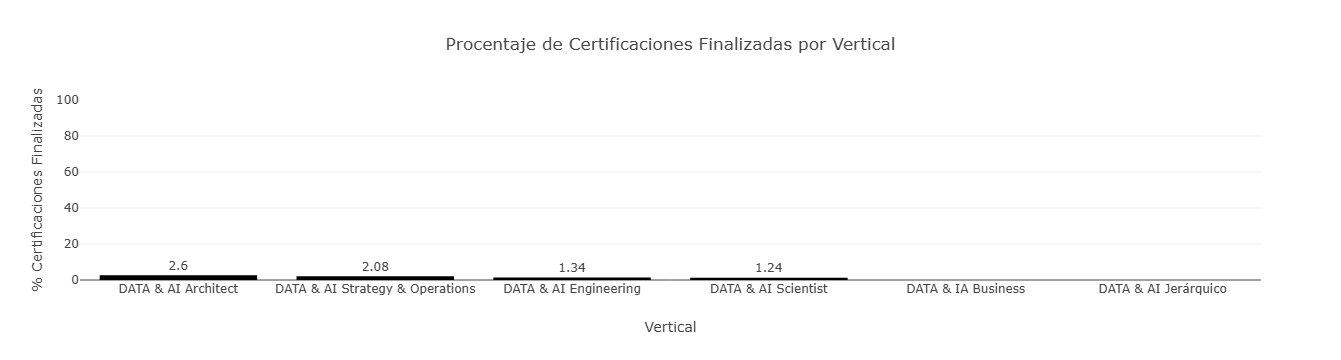

In [102]:
fig = px.bar(data_frame = df_resultado,
             x          = "Vertical",
             y          = "Porcentaje Certificaciones Realizadas",
             range_y    = [0, 100],
             text_auto  = True,
             title      = "Procentaje de Certificaciones Finalizadas por Vertical")

fig.update_layout(xaxis = dict(title = dict(text = "Vertical")),
                  yaxis = dict(title = dict(text = "% Certificaciones Finalizadas")))

fig.show()

# Segunda Gráfica

In [103]:
df = pd.merge(left = df_dicts["Trabajadores"].explode("Nivel").drop("id", axis = 1),
              right = df_dicts["Roles"][["id", "Nivel de carrera MAPFRE"]],
              left_on = "Nivel",
              right_on = "id")

df = df[["Certificaciones", "Certificaciones (from Rol que le corresponde)", "Certificaciones faltantes para el rol (INFORME)", "Nivel de carrera MAPFRE"]]

puestos_orden = ["TÉCNICO AVANZADO",
                 "TÉCNICO SENIOR",
                 "ESPECIALISTA",
                 "EXPERTO",
                 "CONSULTOR",
                 "RESPONSABLE",
                 "JEFE",
                 "SUBDIRECTOR",
                 "DIRECTOR"]

df["Nivel de carrera MAPFRE"] = pd.Categorical(df["Nivel de carrera MAPFRE"], categories = puestos_orden, ordered = True)
df = df.sort_values("Nivel de carrera MAPFRE")

df = df.reset_index(drop = True)

df["Certificaciones Totales"] = df["Certificaciones"].apply(lambda x : len(x) if type(x) == list else 0)

df["Certificaciones Totales por Rol"] = df["Certificaciones (from Rol que le corresponde)"].apply(lambda x : len(x) if type(x) == list else 0)

df["Certificaciones Faltantes"] = df["Certificaciones faltantes para el rol (INFORME)"].apply(lambda x : len(x) if type(x) == list else 0)

df["Porcentaje Certificaciones Faltantes"] = np.round(df["Certificaciones Faltantes"] / df["Certificaciones Totales por Rol"] * 100, 2)

df_resultado = df.groupby(by = ["Nivel de carrera MAPFRE"], as_index = False).agg({"Porcentaje Certificaciones Faltantes" : "mean"})

df_resultado["Porcentaje Certificaciones Faltantes"] = df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)
df_resultado["Porcentaje Certificaciones Realizadas"] = 100 - df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)

df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]] = df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]].round(decimals = 2)

# df_resultado = df_resultado.sort_values("Porcentaje Certificaciones Faltantes")

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\667183489.py:31: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



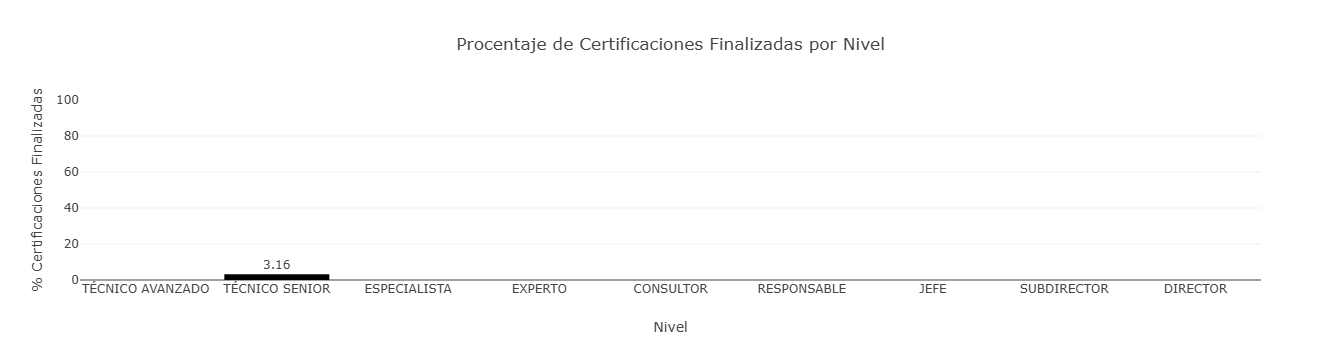

In [105]:
fig = px.bar(data_frame = df_resultado,
             x          = "Nivel de carrera MAPFRE",
             y          = "Porcentaje Certificaciones Realizadas",
             range_y    = [0, 100],
             text_auto  = True,
             title      = "Procentaje de Certificaciones Finalizadas por Nivel")

fig.update_layout(xaxis = {"title" : {"text" : "Nivel"}},
                  yaxis = {"title" : {"text" : "% Certificaciones Finalizadas"}})

fig.show()

# Tercera Gráfica

In [137]:
# Certificaciones más predominantes por Rol
pd.merge(left = df_dicts["Certificaciones"].explode("Roles").groupby(by = ["Certificaciones", "Roles"], as_index = False).agg({"id" : "count"}).sort_values(by = "id", ascending = False),
         right = df_dicts["Verticales"][["id", "Vertical"]],
         left_on = "Roles",
         right_on = "id")

,Certificaciones,Roles,id_x,id_y,Vertical


In [167]:
# Roles y Cartificaciones
df_rol_certificaciones = pd.merge(left = df_dicts["Certificaciones"].explode("Roles").groupby(by = ["Certificaciones", "Roles"], as_index = False).agg({"id" : "count"}).sort_values(by = "id", ascending = False),
         right = df_dicts["Roles"][["id", "Puesto"]],
         left_on = "Roles",
         right_on = "id")[["Certificaciones", "Puesto"]]

df_rol_certificaciones.columns = ["Certificaciones", "Rol"]

df_rol_certificaciones.head(3)

,Certificaciones,Rol
0,AI For Everyone – Andrew Ng,DATA & AI Business Specialist
1,AWS AI and Deep Learning Courses (Skill Builder),DATA & AI Scientist
2,AWS Certified Advanced Networking Specialty,DATA & AI Engineer


In [168]:
# Roles y Vertical

df_roles_vertical = pd.merge(left     = df_dicts["Trabajadores"][["Nuevo puesto", "Nueva vertical"]].explode("Nueva vertical").drop_duplicates(),
                             right    = df_dicts["Verticales"][["id", "Vertical"]],
                             left_on  = "Nueva vertical",
                             right_on = "id",
                             how      = "left")[["Nuevo puesto", "Vertical"]]

df_roles_vertical.columns = ["Rol", "Vertical"]

df_roles_vertical

,Rol,Vertical
0,DATA & AI Scientist,DATA & AI Scientist
1,DATA & AI Strategy & Operations Consultant,DATA & AI Strategy & Operations
2,DATA & AI Architect,DATA & AI Architect
3,Jefe de DATA & IA,DATA & AI Jerárquico
4,DATA & IA Business Analyst Senior,DATA & IA Business
5,DATA & IA Business Analyst Specialist,DATA & IA Business
6,DATA & IA Business Analyst Expert,DATA & IA Business
7,DATA & AI Business Analyst,DATA & IA Business
8,DATA & AI Strategy & Operations Analyst Senior,DATA & AI Strategy & Operations
9,DATA & AI Scientist Senior,DATA & IA Business


In [172]:
pd.merge(left = df_rol_certificaciones,
         right = df_roles_vertical,
         left_on = "Rol",
         right_on = "Rol",
         how = "inner").groupby(by = ["Vertical", "Certificaciones"], as_index = False).agg({"Rol" : "count"})

,Vertical,Certificaciones,Rol
0,DATA & AI Architect,AWS Certified Advanced Networking Specialty,2
1,DATA & AI Architect,AWS Certified Cloud Practitioner (CLF-C01),1
2,DATA & AI Architect,AWS Certified Data Analytics – Specialty (DAS-...,2
3,DATA & AI Architect,AWS Certified DevOps Engineer – Professional (...,2
4,DATA & AI Architect,AWS Certified Developer – Associate (DVA-C02),2
...,...,...,...
100,DATA & IA Business,Google Cloud Certified: Professional Data Engi...,1
101,DATA & IA Business,Google Data Analytics Professional Certificate,1
102,DATA & IA Business,Hugging Face Transformers Certification,1
103,DATA & IA Business,NVIDIA Certified AI Developer,1


In [112]:
# Tecnología asociada más predominante por Rol
df_dicts["Certificaciones"].explode("Roles").groupby(by = "Tecnología asociada", as_index = False).agg({"Roles" : "count"}).sort_values(by = "Roles", ascending = False)

,Tecnología asociada,Roles
0,AWS,41
2,Azure,31
11,Google Cloud,20
5,Databricks,14
8,General,11
18,Microsoft / Power BI,6
27,Snowflake,6
10,Google,5
3,DAMA,4
29,Terraform,4


In [113]:
# Nivel asociado más predominante por Rol
df_dicts["Certificaciones"].explode("Roles").groupby(by = "Nivel asociado", as_index = False).agg({"Roles" : "count"}).sort_values(by = "Roles", ascending = False)

,Nivel asociado,Roles
0,Avanzado,84
2,Intermedio,61
1,Básico,29


In [120]:
# Certificaciones por finalizadas por Rol

# [x for x in df_dicts["Trabajadores"].columns if "ertifi" in x]

certificaciones_sin_finalizar = df_dicts["Trabajadores"][["Certificaciones", "Certificaciones faltantes para el rol (INFORME)"]].apply(lambda row : [x for x in row[1] if x not in row[0]] if type(row[0]) == list and type(row[1]) == list else row[1], axis = 1)

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\342993451.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [130]:
pd.merge(left     = pd.DataFrame(data = certificaciones_sin_finalizar.explode(), columns = ["certificaciones_id"]),
         right    = df_dicts["Certificaciones"],
         left_on  = "certificaciones_id",
         right_on = "id",
         how      = "left").groupby(by = "Certificaciones", as_index = False).agg({"id" : "count"}).sort_values("id", ascending = False)

,Certificaciones,id
12,Azure AI Engineer Associate (AI-102),30
7,AWS Certified Machine Learning – Specialty (ML...,30
4,AWS Certified Data Analytics – Specialty (DAS-...,29
34,Google Cloud Certified: Professional Data Engi...,27
35,Google Cloud Certified: Professional Machine L...,21
...,...,...
20,Certified Analytics Professional (CAP),2
51,PgMP (Program Management Professional – PMI),2
30,Financial Modeling and Forecasting Financial S...,1
50,PMI Agile Certified Practitioner (PMI-ACP),1


# Veredicto

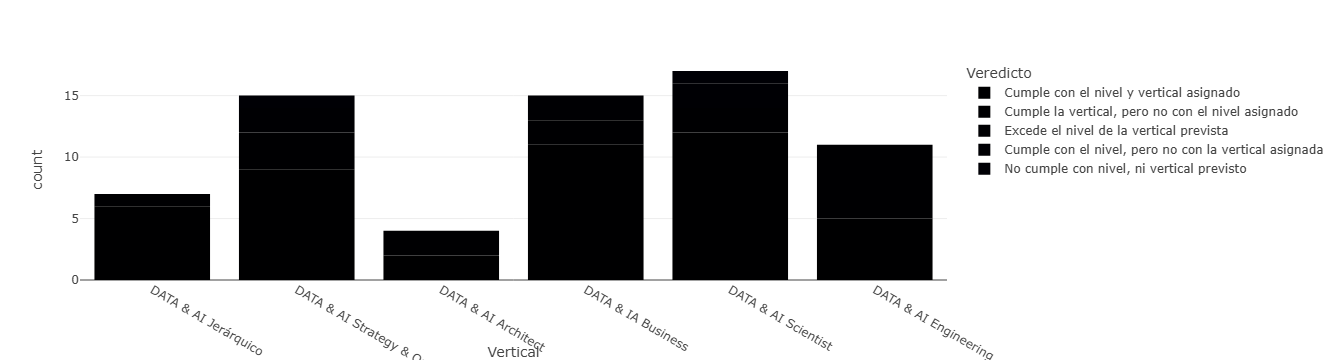

In [210]:
# Vertical y Veredicto

def grafica_veredicto_vertical(df_dicts):
    df_vertical_veredicto = pd.merge(left = df_dicts["Trabajadores"].explode("Nueva vertical").groupby(by = ["Nueva vertical", "Veredicto"], as_index = False).agg({"id" : "count"}),
                                     right = df_dicts["Verticales"][["id", "Vertical"]],
                                     left_on = "Nueva vertical",
                                     right_on = "id")[["Vertical", "Veredicto", "id_x"]]
    
    df_vertical_veredicto.columns = ["Vertical", "Veredicto", "count"]
    
    veredicto_orden = ["Cumple con el nivel y vertical asignado",
                       "Cumple la vertical, pero no con el nivel asignado",
                       "Excede el nivel de la vertical prevista",
                       "Cumple con el nivel, pero no con la vertical asignada",
                       "No cumple con nivel, ni vertical previsto"]
    
    df_vertical_veredicto["Veredicto"] = pd.Categorical(df_vertical_veredicto["Veredicto"], categories = veredicto_orden, ordered = True)
    df_vertical_veredicto = df_vertical_veredicto.sort_values("Veredicto")
    
    fig = px.bar(data_frame = df_vertical_veredicto, x = "Vertical", y = "count", color = "Veredicto")

    return fig

grafica_veredicto_vertical(df_dicts)

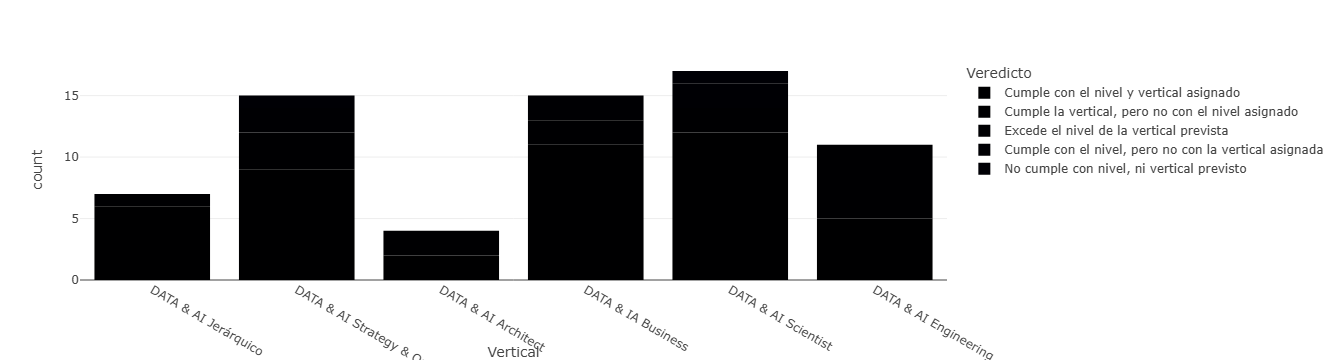

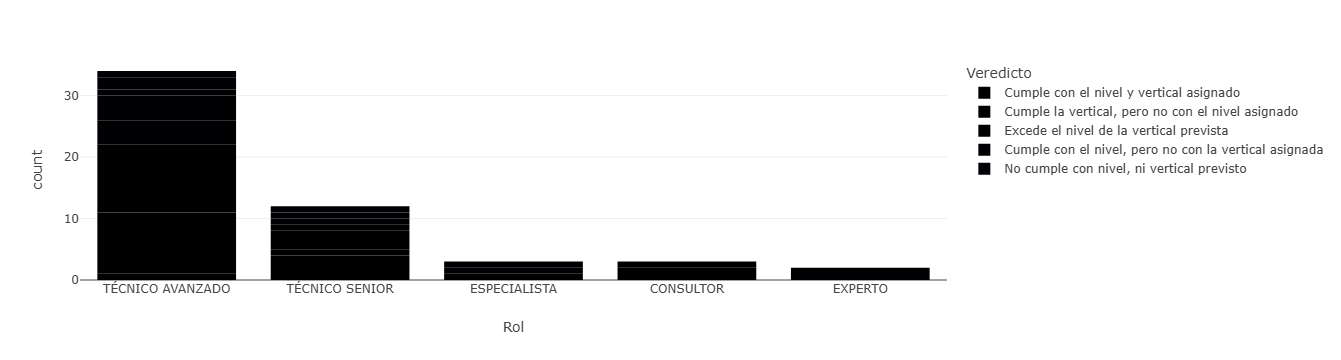

In [209]:
# Rol y Veredicto
df_rol_veredicto = pd.merge(left = df_dicts["Trabajadores"].explode("Nuevo puesto").groupby(by = ["Nuevo puesto", "Veredicto"], as_index = False).agg({"id" : "count"}),
                            right = df_dicts["Roles"][["Nivel de carrera MAPFRE", "Puesto"]],
                            left_on = "Nuevo puesto",
                            right_on = "Puesto")[["Nivel de carrera MAPFRE", "Veredicto", "id"]]

df_rol_veredicto.columns = ["Rol", "Veredicto", "count"]

veredicto_orden = ["Cumple con el nivel y vertical asignado",
                   "Cumple la vertical, pero no con el nivel asignado",
                   "Excede el nivel de la vertical prevista",
                   "Cumple con el nivel, pero no con la vertical asignada",
                   "No cumple con nivel, ni vertical previsto"]

df_rol_veredicto["Veredicto"] = pd.Categorical(df_rol_veredicto["Veredicto"], categories = veredicto_orden, ordered = True)
df_rol_veredicto = df_rol_veredicto.sort_values("Veredicto")

px.bar(data_frame = df_rol_veredicto, x = "Rol", y = "count", color = "Veredicto")